## Accessing Data in Cloud-Optimized GeoTIFFs (COGs) with `stars` in R

Cloud-Optimized GeoTIFFs (COGs) are an optimized variant of the GeoTIFF format that enables efficient, scalable access to raster data. By structuring data in cloud-friendly tiles and enabling partial reads, COGs minimize storage and bandwidth requirements while improving performance for remote sensing and GIS workflows.

This notebook will demonstrate how `stars` can efficiently read and visualize COGs while leveraging their internal structure for optimal data access. Although users typically do not need to consider tiling explicitly, understanding the layout of COGs can help design workflows that take full advantage of their efficiency. Another option for accessing cogs in in R is the `terra` package, for which another version of this notebook is available [here](./accessing-cogs-in-r-terra.html).

Because COGs offer substantial performance benefits with minimal overhead, it is a best practice to always generate valid COGs when writing GeoTIFFs. For more information, see the [guide on writing COGs with python](./writing-cogs-in-python.html).

If you're unsure whether a given GeoTIFF is a COG, refer to this [guide on COG validation](./cogs-examples.html#is-it-a-valid-cog)

---

### **Demonstration Goals**
This notebook demonstrates how `stars` can be used to access and process COGs efficiently in R:

- **Accessing Metadata:**  
  - Using `stars` to retrieve key metadata such as dimensions, resolution, projection, and internal tiling structure.
  
- **Visualizing the Internal Tiling Structure:**  
  - Overlaying a grid to illustrate how the dataset is structured into tiles.

- **Reading Specific Regions:**  
  - Extracting a tile-aligned region to demonstrate efficient data access.
  - Extracting a region spanning multiple tiles to illustrate how misalignment affects performance.

---

### **Key Takeaways**
- **COGs allow efficient, selective access to raster data**, avoiding the need to download full datasets.
- **Aligning reads with internal tile grids** optimizes performance by minimizing unnecessary data transfer.
- **Even misaligned access benefits from COGs' optimized structure**, making them more efficient than standard GeoTIFFs.
- **`stars` provides a powerful and flexible interface** for working with COGs in R, making cloud-native raster workflows seamless.

By the end of this notebook, you will have a practical understanding of how to use `stars` for accessing and processing COGs efficiently.

## Environment

The packages needed for this notebook can be installed with `conda` or `mamba`. Using the [`environment.yml` from this folder](./environment.yml) run:

```bash
conda env create -f environment.yml
```

or

```bash
mamba env create -f environment.yml
```

Finally, you may activate and select the kernel in the notebook (running in Jupyter)

```bash
conda activate coguide-cog
```

The notebook has been tested to work with the listed Conda environment.

### TL;DR: Efficiently Read and Display the Bottom Half of a COG

This example demonstrates how to efficiently extract and display the **bottom half** of a Cloud-Optimized GeoTIFF (COG) using `stars`. Instead of reading the full dataset, we request only the portion we need, taking advantage of the optimized access patterns of COGs.

**NOTE**: it is very important to set `proxy` to true when calling `read_stars` to take full advantage of COG partial reads!

Loading required package: abind

Loading required package: sf

Linking to GEOS 3.13.0, GDAL 3.10.1, PROJ 9.5.1; sf_use_s2() is TRUE

Note: sf is linked to a GDAL version without netCDF driver, some tests or examples may fail

Warning message in CPL_read_gdal(as.character(x), as.character(options), as.character(driver), :
“GDAL Message 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed”
Warning message in CPL_read_gdal(as.character(x), as.character(options), as.character(driver), :
“GDAL Message 1: The definition of projected CRS EPSG:32612 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.”
Warning message in CPL_read_gdal(as.character(x), as.character(options), as.character(driver), :
“GDAL Messa

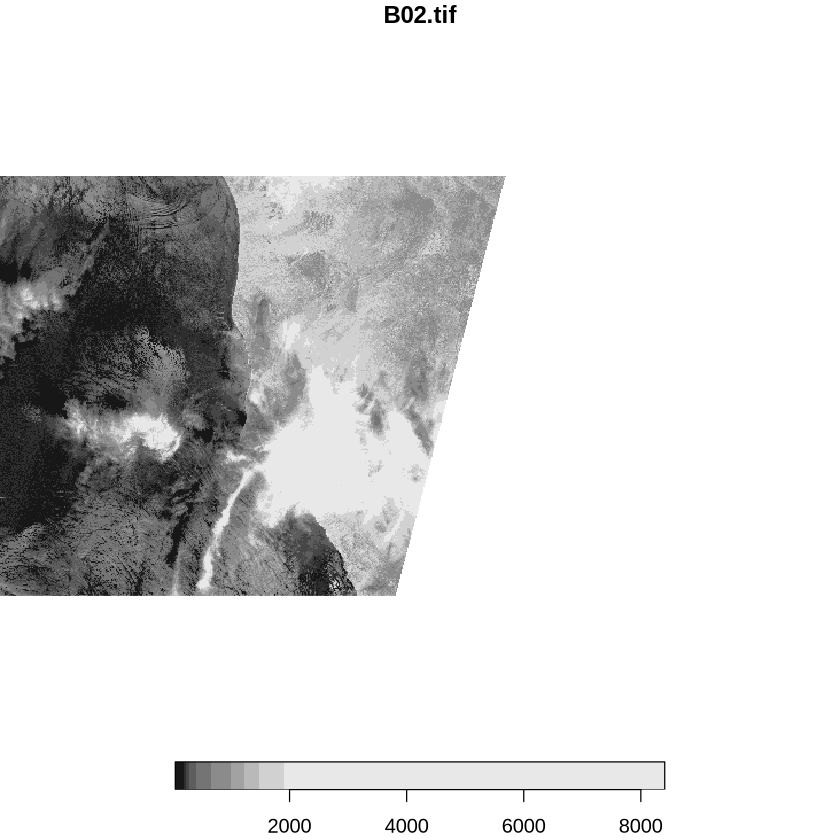

In [1]:
# Load required library
library(stars)
par(new=FALSE)
# Define the COG URL (public Sentinel-2 COG)
cog_url <- "/vsis3/sentinel-cogs/sentinel-s2-l2a-cogs/12/R/UU/2024/4/S2A_12RUU_20240421_0_L2A/B02.tif"

# Set environment variables
Sys.setenv(AWS_NO_SIGN_REQUEST = "YES")
Sys.setenv(GDAL_DISABLE_READDIR_ON_OPEN = "EMPTY_DIR")

# proxy=TRUE ensures only metadata is read at this point
r <- read_stars(cog_url, proxy = TRUE)

# Extract raster dimensions
dims <- st_dimensions(r)
yOffset <- dims$y$to / 2  # Start at the midpoint (bottom half)
ySize <- dims$y$to / 2     # Capture half the height
xSize <- dims$x$to         # Use full width

# Define RasterIO parameters for efficient reading of only a subset of the total data
rasterio <- list(nYOff = yOffset, nXSize = xSize, nYSize = ySize, bands = c(1))

# Read the bottom half of the raster efficiently
x <- read_stars(cog_url, RasterIO = rasterio)

# Plot the extracted bottom half
plot(x)

## Detailed Demonstration

Now that we've seen how to quickly and efficiently read a specific region of a Cloud-Optimized GeoTIFF (COG) in the TL;DR section immediately above, let’s explore things in greater detail.

### Setting Up for Cloud-Optimized GeoTIFF (COG) Access with `stars`

This section configures the environment and prepares stars to access a Cloud-Optimized GeoTIFF (COG) hosted on AWS.

#### 1. Loading stars
The only library required for this workflow is **`stars`**, which provides powerful tools for geospatial data analysis in R.

#### 2. Configuring the environment
To enable seamless access to publicly accessible data on AWS:
- **Anonymous Access**:
  - AWS-hosted public datasets allow anonymous access without credentials. This is enabled by setting the `AWS_NO_SIGN_REQUEST` environment variable to `"YES"`. This configuration ensures that GDAL makes unsigned requests when accessing the file.
  
- **Metadata from File Header**:
  - By setting the `GDAL_DISABLE_READDIR_ON_OPEN` environment variable to `"EMPTY_DIR"`, we inform GDAL that all necessary metadata is contained within the file header. This avoids unnecessary checks for external "sidecar" metadata files, improving efficiency.

For more configuration options, consult the [GDAL configuration documentation](https://gdal.org/en/stable/user/configoptions.html).

#### 3. Defining the COG URL
The file is accessed using its virtual filesystem (VSI) path:
- The path `/vsis3/` indicates that the file is hosted on Amazon S3.
- This example points to a Sentinel-2 COG available in the public Sentinel COG dataset. 
- GDAL supports other virtual filesystems, including `http`, `zip`, `tar`, and combinations thereof. For details, see [GDAL virtual filesystem documentation](https://gdal.org/en/stable/user/virtual_file_systems.html).

#### 4. Opening the COG and Inspecting Metadata
Using the `read_stars()` function from `stars`, we create a reference to the COG:
- **Important Note**: We set `proxy=True` here to make sure that no data is downloaded at this stage! Only the file's metadata is read.
- Metadata includes details such as resolution, coordinate reference system (CRS), and geographic extent, which can be accessed immediately without fetching pixel data.

In [2]:
library(stars)

Sys.setenv(AWS_NO_SIGN_REQUEST = "YES")
Sys.setenv(GDAL_DISABLE_READDIR_ON_OPEN = "EMPTY_DIR")

cog_url <- "/vsis3/sentinel-cogs/sentinel-s2-l2a-cogs/12/R/UU/2024/4/S2A_12RUU_20240421_0_L2A/B02.tif"
r <- read_stars(cog_url, proxy = TRUE)
print(r)

Warning message in CPL_read_gdal(as.character(x), as.character(options), as.character(driver), :
“GDAL Message 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed”
Warning message in CPL_read_gdal(as.character(x), as.character(options), as.character(driver), :
“GDAL Message 1: The definition of projected CRS EPSG:32612 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.”


stars_proxy object with 1 attribute in 1 file(s):
$B02.tif
[1] "[...]/B02.tif"

dimension(s):
  from    to  offset delta                refsys point x/y
x    1 10980   3e+05    10 WGS 84 / UTM zone 12N FALSE [x]
y    1 10980 3400020   -10 WGS 84 / UTM zone 12N FALSE [y]


### Exploring Metadata with `gdalinfo`

Before diving further into visualization or analysis, it's essential to understand the structure and metadata of the Cloud-Optimized GeoTIFF (COG) we're working with. Metadata provides critical insights about the file, such as:

- **Dimensions**: The raster's size in pixels.
- **Projection**: The coordinate reference system (CRS) used for the dataset.
- **Resolution**: The pixel size in geographic or projected units.
- **Tile Information**: The internal structure of the COG (e.g., block size and block layout).
- **Overviews**: Precomputed lower-resolution representations for efficient access.
- **Statistics**: Summary statistics about the dataset's pixel values.

In the following cell, we use the `gdalinfo` command to retrieve this metadata. This step helps verify the internal structure of the TIFF and confirm details like tile size, overview levels, and compression, which are crucial for understanding data access and performance characteristics.

In [3]:
gdalinfo <- system2("gdalinfo", args = c("-stats", cog_url), stdout = TRUE)
cat(gdalinfo, sep = "\n")

Driver: GTiff/GeoTIFF
Files: /vsis3/sentinel-cogs/sentinel-s2-l2a-cogs/12/R/UU/2024/4/S2A_12RUU_20240421_0_L2A/B02.tif
Size is 10980, 10980
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 12N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1,
                    ID["EPSG",9001]]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]],
    CONVERSION["Transverse Mercator",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-111,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPS

### Visualizing the Internal Tile Grid of the COG

After inspecting the metadata with `gdalinfo`, we can use the extracted information to visualize the internal tile grid of the Cloud-Optimized GeoTIFF (COG). This visualization helps confirm how the file is divided into tiles and ensures our understanding aligns with the metadata.

In this cell, we:

1. **Calculate Block Size in Geographic Units**:
   - Using the block size in pixels (from the metadata, typically 1024x1024 for Sentinel-2 COGs) and the raster's resolution, we compute the corresponding geographic dimensions of each tile.

2. **Generate Grid Coordinates**:
   - Grid lines are defined by the tile boundaries. The code to generate such a grid is included in the collapsed code block below.
   - Horizontal (`x`) and vertical (`y`) grid coordinates are calculated to align with the raster's extent, ensuring proper alignment starting from the top-left corner (consistent with COG tiling).

3. **Overlay the Grid on the Raster**:
   - The raster is plotted at a low resolution (using overviews, if available) for performance.
   - Red grid lines are drawn to represent the tile boundaries.
   - The blue rectangle corresponds to the region or window we'll be plotting.

This visualization depicts the COG's internal tiling structure, which is crucial for efficient access to specific regions of the COG.

Warning message in CPL_read_gdal(as.character(x), as.character(options), as.character(driver), :
“GDAL Message 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed”
Warning message in CPL_read_gdal(as.character(x), as.character(options), as.character(driver), :
“GDAL Message 1: The definition of projected CRS EPSG:32612 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.”


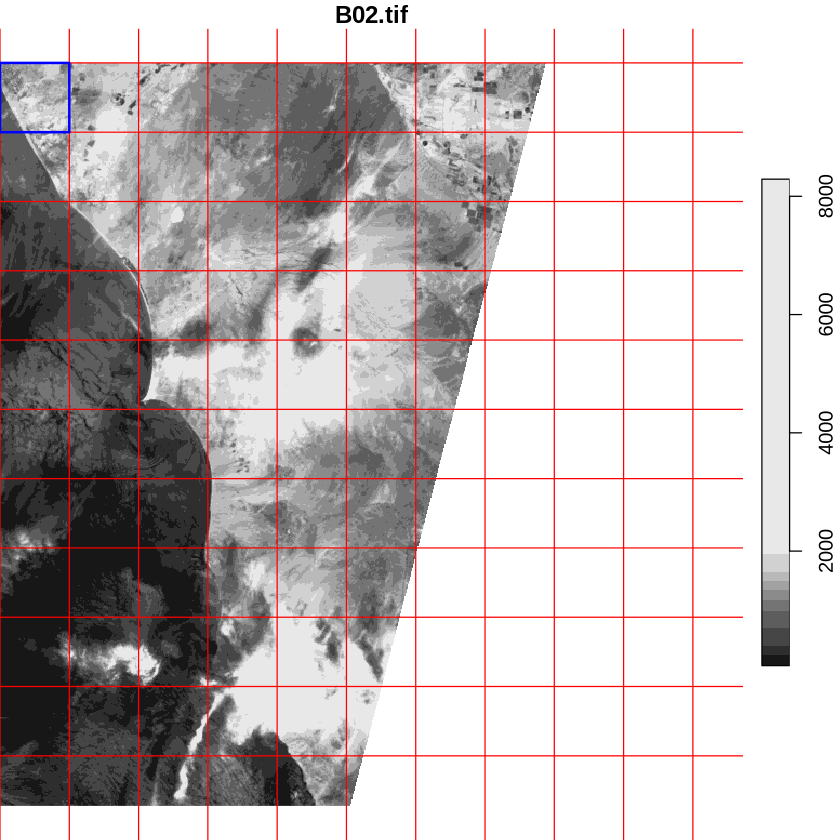

In [4]:
# Extract dimensions and resolution
dims <- st_dimensions(r)
res_x <- dims$x$delta  # Resolution in X direction (units per pixel)
res_y <- dims$y$delta  # Resolution in Y direction (units per pixel)

# Define tile size in pixels
block_size_pixels <- 1024

# Calculate tile size in geographic units
block_size_x <- block_size_pixels * res_x
block_size_y <- block_size_pixels * res_y

# Define extent boundaries for the first tile
first_tile_xmin <- dims$x$offset  # xmin of the raster
first_tile_xmax <- first_tile_xmin + block_size_x
first_tile_ymax <- dims$y$offset
first_tile_ymin <- first_tile_ymax + block_size_y

# Plot the tif preview with grid
plot(
  read_stars(cog_url, options = c("OVERVIEW_LEVEL=3")),
  reset = FALSE
)

# Extract coordinate range and resolution
x_min <- dims$x$offset
x_max <- x_min + (dims$x$delta * (dims$x$to - dims$x$from))
y_max <- dims$y$offset
y_min <- y_max + (dims$y$delta * (dims$y$to - dims$y$from))

# Generate grid coordinates (meters/pixel * 1024 pixels up and down a single tile)
x_coords <- seq(x_min, x_max, by = block_size_x)
y_coords <- seq(y_max, y_min, by = block_size_y)

# Add vertical grid lines
for (x in x_coords) {
  abline(v = x, col = "red")
}

# Add horizontal grid lines
for (y in y_coords) {
  abline(h = y, col = "red")
}

rect(
  xleft  = first_tile_xmin,
  ybottom = min(first_tile_ymin, first_tile_ymax),
  xright = first_tile_xmax,
  ytop   = max(first_tile_ymin, first_tile_ymax),
  border = "blue",
  lwd    = 2
)

### Extracting and Visualizing the First Full Tile (Top-Left 1024x1024 Block)

In this step, we extract the **first full tile** (a 1024x1024 block, represented by the blue square above) of the dataset, aligned with the internal tiling structure of the Cloud-Optimized GeoTIFF (COG). This demonstrates the efficiency of accessing tiles directly, as COGs enable on-demand retrieval of specific data blocks without downloading the entire file.

#### Steps Performed:
1. **Define the Extent**:
   - The geographic extent of the first tile is calculated, starting from the top-left corner of the raster's full extent and spanning the dimensions of one full tile.

2. **Read a Single Tile**:
   - Use the defined `rasterio` to read *only* the part we care about.

3. **Visualize the Tile**:
   - The tile is plotted to confirm its alignment with the internal tiling structure.

This process demonstrates a best-case scenario for access efficiency: all and only the bytes necessary for the selected region are read. While this level of optimization isn't necessary, it illustrates how COGs can minimize data access. In most workflows, reading a few extra bytes is acceptable, but the ability to avoid processing the bulk of a large TIFF is a major advantage enabled by this per-tile access.

Warning message in CPL_read_gdal(as.character(x), as.character(options), as.character(driver), :
“GDAL Message 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed”
Warning message in CPL_read_gdal(as.character(x), as.character(options), as.character(driver), :
“GDAL Message 1: The definition of projected CRS EPSG:32612 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.”
downsample set to 1



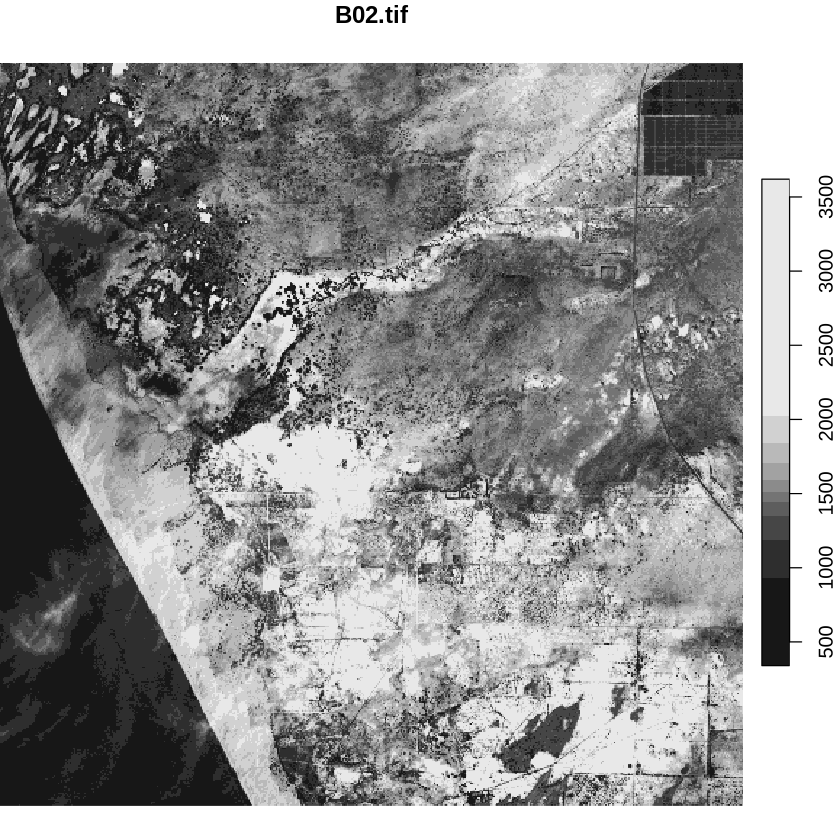

In [5]:
# Define RasterIO parameters to read one of the cog's tiles
rasterio <- list(
  nXOff  = 1,
  nYOff  = 1,
  nXSize = 1024,
  nYSize = 1024,
  bands  = c(1)
)

# Read the defined extent
x <- read_stars(cog_url, RasterIO = rasterio)

# Visualize the first tile
plot(x)

### Visualizing a Region Spanning Multiple Tiles

In this step, we visualize a **1024x1024 region** (the same size as above). This time, however, the window we construct will span portions of 4 internal tiles. This is a less-optimal case because multiple tiles must be accessed to satisfy a single request. From the point of view of someone using the API, things remain seamless. But behind the scenes, 4 times the data is being requested compared to the request above which aligned neatly with the internal tile grid.

#### Steps:
1. **Define the Extent Centered on a Tile Intersection**:
   - The region is centered on the intersection of 4 tiles, ensuring it overlaps multiple internal blocks of the TIFF.
   - Red grid lines represent the boundaries of the internal tiles, showing how the request spans these blocks.

2. **Visualize the Region**:
   - The blue rectangle highlights the requested region, superimposed over the red tile grid lines. This illustrates which tiles will need to be accessed to satisfy the request.

#### Insights:
- The red grid lines illustrate the boundaries of the COG's internal tiling, highlighting the efficiency of accessing data aligned with these tiles.
- The blue rectangle represents the requested region, showing how it spans multiple tiles.
- This step is purely visual: no reading or cropping data yet.

Warning message in CPL_read_gdal(as.character(x), as.character(options), as.character(driver), :
“GDAL Message 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed”
Warning message in CPL_read_gdal(as.character(x), as.character(options), as.character(driver), :
“GDAL Message 1: The definition of projected CRS EPSG:32612 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.”


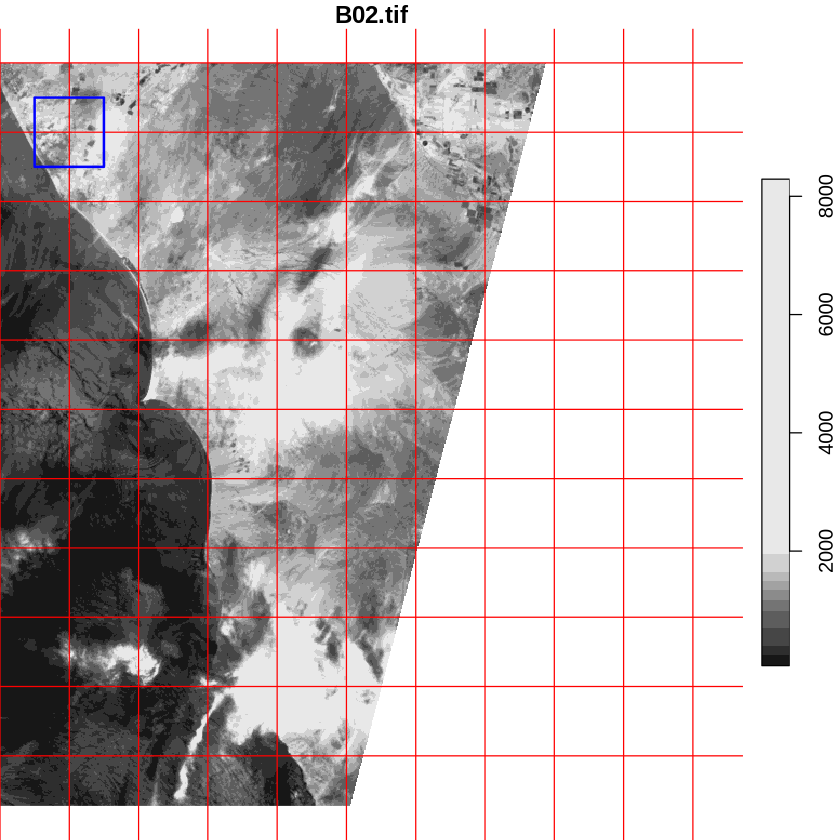

In [6]:
# Plot the tif preview with grid
plot(
  read_stars(cog_url, options = c("OVERVIEW_LEVEL=3")),
  reset = FALSE
)

# Extract coordinate range and resolution
x_min <- dims$x$offset
x_max <- x_min + (dims$x$delta * (dims$x$to - dims$x$from))
y_max <- dims$y$offset
y_min <- y_max + (dims$y$delta * (dims$y$to - dims$y$from))

# Generate grid coordinates (meters/pixel * 1024 pixels up and down a single tile)
x_coords <- seq(x_min, x_max, by = block_size_x)
y_coords <- seq(y_max, y_min, by = block_size_y)

# Add vertical grid lines
for (x in x_coords) {
  abline(v = x, col = "red")
}

# Add horizontal grid lines
for (y in y_coords) {
  abline(h = y, col = "red")
}

rect(
  xleft  = first_tile_xmin + (block_size_x / 2),
  ybottom = min(first_tile_ymin, first_tile_ymax)+ (block_size_y /2),
  xright = first_tile_xmax + (block_size_x /2),
  ytop   = max(first_tile_ymin, first_tile_ymax) - (block_size_x / 2),
  border = "blue",
  lwd    = 2
)

### Extracting and Visualizing the Selected Window

In this step, we read the raster data corresponding to the **blue rectangle** visualized in the previous step. This window spans portions of 4 internal tiles. Again, this is a less-optimal case where data from multiple tiles must be accessed to fulfill a single request.

#### Steps:
1. **Read the Window**:
   - Using the previously defined extent (the blue rectangle), we extract the corresponding raster data. 
   - The operation retrieves data from all 4 tiles that overlap with the window.

2. **Visualize the Region**:
   - The extracted region is plotted, confirming its location and spatial coverage within the raster.

#### Insights:
- While the request spans multiple tiles, the ability to target only the relevant portions of the raster remains far more efficient than downloading the entire file.

Warning message in CPL_read_gdal(as.character(x), as.character(options), as.character(driver), :
“GDAL Message 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed”
Warning message in CPL_read_gdal(as.character(x), as.character(options), as.character(driver), :
“GDAL Message 1: The definition of projected CRS EPSG:32612 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.”
downsample set to 2



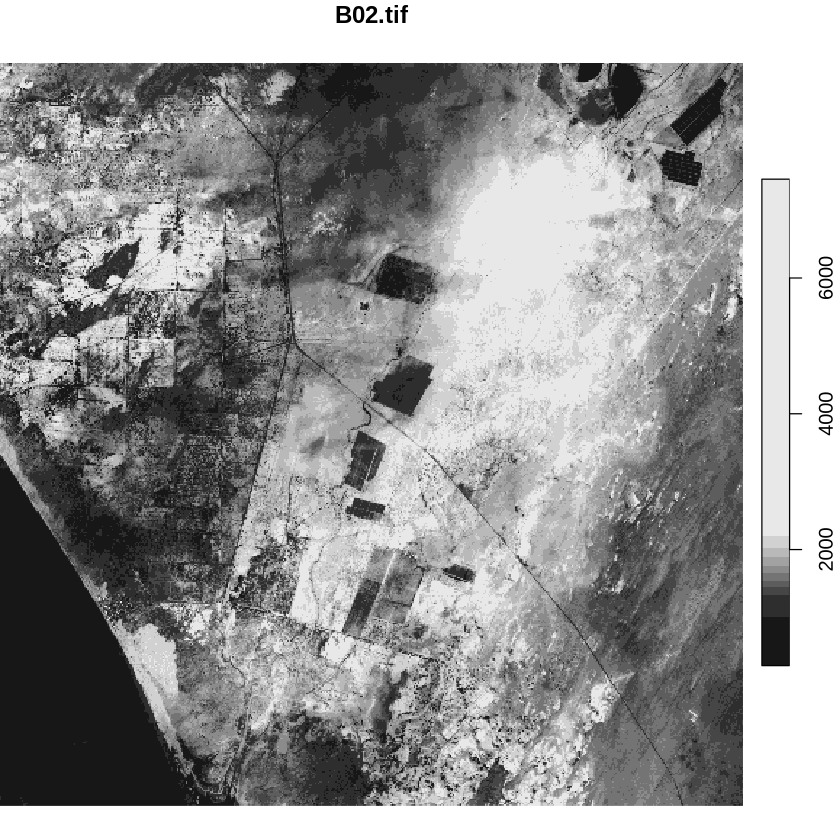

In [7]:
# Define RasterIO parameters to read one of the cog's tiles
rasterio <- list(
  nXOff  = 513,
  nYOff  = 513,
  nXSize = 1536,
  nYSize = 1536,
  bands  = c(1)
)

# Read the defined extent
x <- read_stars(cog_url, RasterIO = rasterio)

# Visualize the first tile
plot(x)

### Review of Key Points

In this notebook, we explored how to efficiently access and process geospatial data stored in a Cloud-Optimized GeoTIFF (COG) using `stars` in R. The key takeaways include:

#### Efficient Data Access:
- COGs allow on-demand access to specific regions of a dataset without requiring the download of the entire file.
- This capability minimizes bandwidth usage, accelerates workflows, and supports scalable analysis of large geospatial datasets.

#### Visualization of Internal Tiling:
- We visualized the internal tile structure of the COG (1024x1024 tiles) by overlaying a grid on the raster. 
- A blue rectangle highlighted the region corresponding to the first tile, illustrating how COGs organize data into blocks for efficient access.

#### Aligned and Unaligned Access:
1. **Aligned Access**:
   - A 1024x1024 region corresponding to the first tile (top-left corner) was extracted.
   - This represents the best-case scenario for COGs, where the requested region aligns perfectly with an internal tile, ensuring minimal data transfer.

2. **Unaligned Access**:
   - A 1024x1024 region spanning portions of 4 tiles was extracted.
   - This less-optimal case demonstrates how misalignment with the internal tile grid increases the amount of data accessed while still avoiding the need to download the entire file.

#### Reflection on Tools:
- The `stars` package provides a powerful and flexible interface for geospatial data processing in R, enabling tasks such as cropping, visualizing, and analyzing raster data.
- By leveraging COG-specific features like internal tiling and on-demand access, workflows can be made more efficient and cost-effective.